creacion y registro del modelo

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import mlflow
import mlflow.spark

# Leer la tabla de hechos
df = spark.table("fact_clothes_price")

# Preparar los datos
feature_cols = [c for c in df.columns if c != "Price"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# -------------------------
# Linear Regression
# -------------------------
lr = LinearRegression(featuresCol="features", labelCol="Price")
lr_pipeline = Pipeline(stages=[assembler, lr])
lr_model = lr_pipeline.fit(train_df)
lr_predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

with mlflow.start_run(run_name="LinearRegressionModel"):
    mlflow.log_metric("rmse", lr_rmse)
    mlflow.spark.log_model(lr_model, "linear_regression_model")

# -------------------------
# Random Forest
# -------------------------
numTrees=80
rf = RandomForestRegressor(featuresCol="features", labelCol="Price", numTrees=numTrees)
rf_pipeline = Pipeline(stages=[assembler, rf])
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)
rf_rmse = evaluator.evaluate(rf_predictions)

with mlflow.start_run(run_name="RandomForestModel"):
    mlflow.log_param("numTrees", numTrees)
    mlflow.log_metric("rmse", rf_rmse)
    mlflow.spark.log_model(rf_model, "random_forest_model")

# Mostrar resultados
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

2025/05/16 16:25:14 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


2025/05/16 16:25:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/308780257718411/ee58984ca000406c81b09371b0d68df4/artifacts/linear_regression_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.2']. Set logging level to DEBUG to see the full traceback. 


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

2025/05/16 16:26:32 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


2025/05/16 16:26:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/308780257718411/ca870418512649c78e21ca503d344ad1/artifacts/random_forest_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.2']. Set logging level to DEBUG to see the full traceback. 


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Linear Regression RMSE: 54.217805327287586
Random Forest RMSE: 55.104798028819


In [0]:
print(feature_cols)
print(f"Intercept: {lr_model.stages[-1].intercept}")
print(f"Coefficients: {lr_model.stages[-1].coefficients}")


['Brand_id', 'Category_id', 'Color_id', 'Size_id', 'Material_id']
Intercept: 106.86644131822966
Coefficients: [-0.9881404537821337,-0.20728787485005531,0.4532020733758495,0.38788662223510567,0.03285518539314388]


revisión resultados

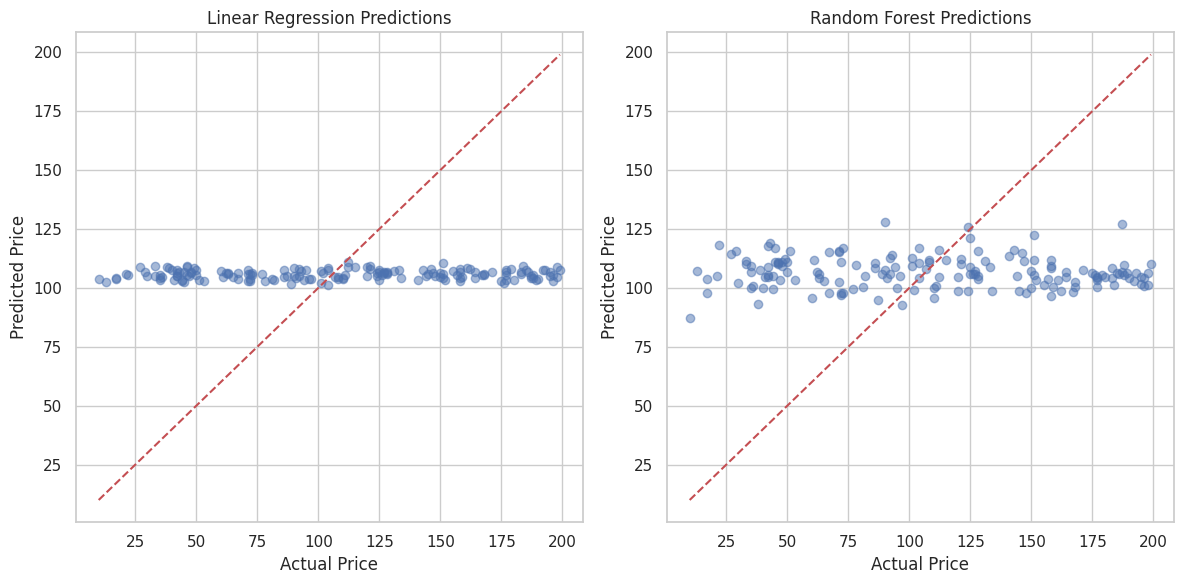

Wrote 42674 bytes.
JSON guardado exitosamente.


In [0]:
import json

# Convertir a Pandas con todas las columnas necesarias
selected_cols = [
    "Brand_id", "Category_id", "Color_id", "Size_id", "Material_id",
    "Price", "features", "prediction"
]

lr_pd = lr_predictions.select(*selected_cols).toPandas()
rf_pd = rf_predictions.select(*selected_cols).toPandas()

# Graficar
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(lr_pd["Price"], lr_pd["prediction"], alpha=0.5)
plt.plot([lr_pd["Price"].min(), lr_pd["Price"].max()], [lr_pd["Price"].min(), lr_pd["Price"].max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression Predictions")

plt.subplot(1, 2, 2)
plt.scatter(rf_pd["Price"], rf_pd["prediction"], alpha=0.5)
plt.plot([rf_pd["Price"].min(), rf_pd["Price"].max()], [rf_pd["Price"].min(), rf_pd["Price"].max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest Predictions")

plt.tight_layout()
plt.show()

# Guardar resultados en JSON (sin incluir features, que no es JSON serializable directamente)
lr_json = lr_pd.drop(columns=["features"]).to_dict(orient="records")
rf_json = rf_pd.drop(columns=["features"]).to_dict(orient="records")

results = {
    "LinearRegression": {
        "rmse": lr_rmse,
        "predictions": lr_json
    },
    "RandomForest": {
        "rmse": rf_rmse,
        "predictions": rf_json
    }
}

json_string = json.dumps(results)

# Guardar en DBFS
dbutils.fs.put('/FileStore/tables/model_predictions.json', json_string, overwrite=True)

print("JSON guardado exitosamente.")


In [0]:
print(json_string)

{"LinearRegression": {"rmse": 54.217805327287586, "predictions": [{"Brand_id": 1, "Category_id": 1, "Color_id": 2, "Size_id": 1, "Material_id": 5, "Price": 155.0, "prediction": 107.12957968555}, {"Brand_id": 1, "Category_id": 1, "Color_id": 3, "Size_id": 1, "Material_id": 4, "Price": 185.0, "prediction": 107.5499265735327}, {"Brand_id": 1, "Category_id": 1, "Color_id": 3, "Size_id": 5, "Material_id": 6, "Price": 33.0, "prediction": 109.16718343325941}, {"Brand_id": 1, "Category_id": 1, "Color_id": 4, "Size_id": 5, "Material_id": 2, "Price": 46.0, "prediction": 109.48896476506269}, {"Brand_id": 1, "Category_id": 1, "Color_id": 5, "Size_id": 2, "Material_id": 2, "Price": 120.0, "prediction": 108.77850697173322}, {"Brand_id": 1, "Category_id": 1, "Color_id": 5, "Size_id": 6, "Material_id": 5, "Price": 151.0, "prediction": 110.42861901685308}, {"Brand_id": 1, "Category_id": 1, "Color_id": 6, "Size_id": 6, "Material_id": 5, "Price": 112.0, "prediction": 110.88182109022893}, {"Brand_id": 1, 